# Custom Training Basics

In this ungraded lab you'll gain a basic understanding of building custom training loops. 
- It takes you through the underlying logic of fitting any model to a set of inputs and outputs. 
- You will be training your model on the linear equation for a straight line, wx + b. 
- You will implement basic linear regression from scratch using gradient tape.
- You will try to minimize the loss incurred by the model using linear regression.

## Imports

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.3.1


## Define Model

You define your model as a class. 
- `x` is your input tensor. 
- The model should output values of **wx+b**. 
- You'll start off by initializing w and b to random values. 
- During the training process, values of w and b get updated in accordance with linear regression so as to minimize the loss incurred by the model. 
- Once you arrive at optimal values for w and b, the model would have been trained to correctly predict the values of wx+b.

Hence, 
- **w** and **b** are trainable weights of the model. 
- **x** is the input
- **y** = wx + b is the output

In [4]:
class Model(object):
  def __init__(self):
    # Initialize the weights to `2.0` and the bias to `1.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.w = tf.Variable(2.0)
    self.b = tf.Variable(1.0)

  def __call__(self, x):
    return self.w * x + self.b

model = Model()

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. 
- The goal is to minimize this difference during training. 
- Let's use the standard L2 loss, also known as the least square errors
$$Loss = \sum_{i} \left (y_{pred}^i - y_{target}^i \right )^2$$

In [5]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

### Obtain training data

First, synthesize the training data using the "true" w and "true" b. 

$$y = w_{true} \times x + b_{true} $$

In [6]:
TRUE_w = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

xs  = tf.random.normal(shape=[NUM_EXAMPLES])

ys = (TRUE_w * xs) + TRUE_b

Before training the model, visualize the loss value by plotting the model's predictions in red crosses and the training data in blue dots:

In [7]:
def plot_data(inputs, outputs, predicted_outputs):
  real = plt.scatter(inputs, outputs, c='b', marker='.')
  predicted = plt.scatter(inputs, predicted_outputs, c='r', marker='+')
  plt.legend((real,predicted), ('Real Data', 'Predicted Data'))
  plt.show()

In [8]:
plot_data(xs, ys, model(xs))
print('Current loss: %1.6f' % loss(model(xs), ys).numpy())

Current loss: 1.959480


### Define a training loop

With the network and training data, train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) 
- Gradient descent updates the trainable weights **w** and **b** to reduce the loss. 


There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer`—our recommended implementation. In the spirit of building from first principles, here you will implement the basic math yourself.
- You'll use `tf.GradientTape` for automatic differentiation
- Use `tf.assign_sub` for decrementing a value.  Note that assign_sub combines `tf.assign` and `tf.sub`

In [9]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dw, db = t.gradient(current_loss, [model.w, model.b])
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

  return current_loss

Finally, you can iteratively run through the training data and see how `w` and `b` evolve.

In [10]:
model = Model()

# Collect the history of W-values and b-values to plot later
list_w, list_b = [], []
epochs = range(15)
losses = []
for epoch in epochs:
  list_w.append(model.w.numpy())
  list_b.append(model.b.numpy())
  current_loss = train(model, xs, ys, learning_rate=0.1)
  losses.append(current_loss)
  print('Epoch %2d: w=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, list_w[-1], list_b[-1], current_loss))

Epoch  0: w=2.00 b=1.00, loss=1.95948
Epoch  1: w=2.19 b=1.20, loss=1.26675
Epoch  2: w=2.35 b=1.36, loss=0.81894
Epoch  3: w=2.48 b=1.48, loss=0.52945
Epoch  4: w=2.58 b=1.59, loss=0.34230
Epoch  5: w=2.66 b=1.67, loss=0.22131
Epoch  6: w=2.73 b=1.73, loss=0.14309
Epoch  7: w=2.78 b=1.79, loss=0.09251
Epoch  8: w=2.82 b=1.83, loss=0.05982
Epoch  9: w=2.86 b=1.86, loss=0.03868
Epoch 10: w=2.88 b=1.89, loss=0.02501
Epoch 11: w=2.91 b=1.91, loss=0.01617
Epoch 12: w=2.92 b=1.93, loss=0.01046
Epoch 13: w=2.94 b=1.94, loss=0.00676
Epoch 14: w=2.95 b=1.95, loss=0.00437


In addition to the values for losses, you also plot the progression of trainable variables over epochs.

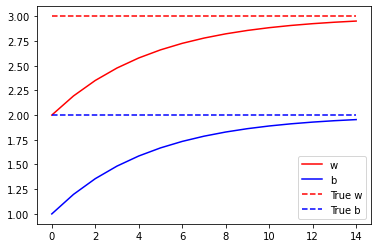

In [11]:
plt.plot(epochs, list_w, 'r',
       epochs, list_b, 'b')
plt.plot([TRUE_w] * len(epochs), 'r--',
      [TRUE_b] * len(epochs), 'b--')
plt.legend(['w', 'b', 'True w', 'True b'])
plt.show()

## Plots for Evaluation
Now you can plot the actual outputs in red and the model's predictions in blue on a set of random test examples.

You can see that the model is able to make predictions on the test set fairly accurately.

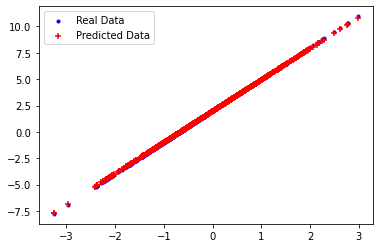

In [12]:
test_inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
test_outputs = test_inputs * TRUE_w + TRUE_b

predicted_test_outputs = model(test_inputs)
plot_data(test_inputs, test_outputs, predicted_test_outputs)

Visualize the cost function against the values of each of the trainable weights the model approximated to over time.

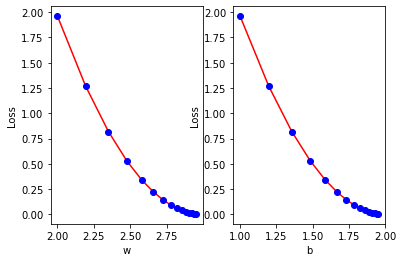

In [13]:
def plot_loss_for_weights(weights_list, losses):
  for idx, weights in enumerate(weights_list):
    plt.subplot(120 + idx + 1)
    plt.plot(weights['values'], losses, 'r')
    plt.plot(weights['values'], losses, 'bo')
    plt.xlabel(weights['name'])
    plt.ylabel('Loss')
    
    
weights_list = [{ 'name' : "w",
                  'values' : list_w
                },
                {
                  'name' : "b",
                  'values' : list_b
                }]

plot_loss_for_weights(weights_list, losses)